In [192]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import seaborn as sns

# import custom functions
from corrmat_functions import *

In [193]:
msts = np.load('data/msts.npy', allow_pickle='TRUE').item()
pmfgs = np.load('data/pmfgs.npy', allow_pickle='TRUE').item()


#changing pmfgs so it has the same layout as msts

#setting tickers as node attributes for pmfgs
for i, (k,pmfg) in enumerate(sorted(pmfgs.items())):
    tickers = {index: stockname for index, stockname in enumerate(pmfg['ticker'])}
    nx.set_node_attributes(pmfg['network'], tickers , 'ticker')

#changing dictionary structure to { <timestamp> : <pmfg> }
pmfgs = {k:v['network'] for k,v in pmfgs.items()}

In [194]:
#testing
mst = msts[list(sorted(msts.keys()))[0]]
pmfg = pmfgs[list(sorted(pmfgs.keys()))[0]]

In [195]:
sum(dict(nx.shortest_path_length(mst))[0].values())

50

In [196]:
nx.degree_centrality(mst)

{0: 0.041666666666666664,
 1: 0.9166666666666666,
 2: 0.041666666666666664,
 3: 0.041666666666666664,
 4: 0.041666666666666664,
 5: 0.041666666666666664,
 6: 0.041666666666666664,
 7: 0.041666666666666664,
 8: 0.041666666666666664,
 9: 0.08333333333333333,
 10: 0.041666666666666664,
 11: 0.041666666666666664,
 12: 0.041666666666666664,
 13: 0.041666666666666664,
 14: 0.041666666666666664,
 15: 0.041666666666666664,
 16: 0.041666666666666664,
 17: 0.08333333333333333,
 18: 0.041666666666666664,
 19: 0.041666666666666664,
 20: 0.041666666666666664,
 21: 0.041666666666666664,
 22: 0.041666666666666664,
 23: 0.041666666666666664,
 24: 0.041666666666666664}

In [197]:
#properties to consider
# https://www.sciencedirect.com/science/article/pii/S2214845020300521
# Nodes	Avg.Degree	Pathlength	Betweenness Centrality	Closeness Centrality	Power Lawa p(k) ∼ k−    

# https://link.springer.com/article/10.1007/s10614-016-9627-7
# normalized tree length  
# average path length
# mean occupation layer


#https://link.springer.com/chapter/10.1007/978-3-030-66046-8_21
# centrality measures per node compared over time
# Degree Centrality
# Node Strength
# Betweenness Centrality
# Closeness Centrality
# Eigenvector Centrality

In [225]:
# takes dicionary as input with this structure
# { <timestamp> : <network> }
# it returns a dictionary with all the properties at each timestamp
# {  <timestamp> : 
#           {
#               'nodes' : <value>
#               'degree_average' : <value>
#               'max_degree' : <value>
#                 ....
#           }
# }

def get_network_properties(network_dict):

    network_properties = {}

    for k,G in sorted(network_dict.items()):
        properties = {}

        properties['nodes'] = G.number_of_nodes()
        properties['degree_average'] = np.mean([x[1] for x in list(G.degree())])
        properties['max_degree'] = np.max([x[1] for x in list(G.degree())])
        properties['average_shortest_path_length'] = nx.average_shortest_path_length(G)
        properties['diameter'] = nx.diameter(G)
        properties['normalized_tree_length'] = (1/G.number_of_edges()) * sum(dict(nx.shortest_path_length(G))[0].values())
        #properties['average_path_length'] = (2/(G.number_of_nodes()*G.number_of_edges())) * sum(dict(nx.shortest_path_length(G))[0].values())
        properties['average_degree_centrality'] = np.mean(list(nx.degree_centrality(G).values()))
        properties['average_betweenness_centrality'] = np.mean(list(nx.betweenness_centrality(G).values()))
        properties['average_closeness_centrality'] = np.mean(list(nx.closeness_centrality(G).values()))

        network_properties[k] = properties

    return network_properties


In [227]:
# takes dicionary as input with this structure
# { <timestamp> : <network> }
# it returns a dictionary with centralities at each timestamp
# centralities are saves ad a dictionary with each ticker as key
# {  <timestamp> : 
#           {
#               'degree_centrality' : 
#                       {
#                           'BTC' : <value>,
#                           'ETH' : <value>,  
#                              ..... 
#                       }
#               'betweenness_centrality' : 
#                       {
#                           'BTC' : <value>,
#                           'ETH' : <value>,  
#                              ..... 
#                       }
#                  ........
#           }
# }



def get_network_node_centralities(network_dict):

    network_properties = {}

    for k,G in sorted(network_dict.items()):
        properties = {}

        properties['nodes'] = G.number_of_nodes()
        properties['degree_centrality'] = dict(zip(nx.get_node_attributes(G,'ticker').values(), nx.degree_centrality(G).values()))
        properties['betweenness_centrality'] = dict(zip(nx.get_node_attributes(G,'ticker').values(), nx.betweenness_centrality(G).values()))
        properties['closeness_centrality'] =  dict(zip(nx.get_node_attributes(G,'ticker').values(), nx.closeness_centrality(G).values()))
        properties['eigenvector_centrality'] = dict(zip(nx.get_node_attributes(G,'ticker').values(), nx.eigenvector_centrality(G).values()))


        network_properties[k] = properties

    return network_properties


In [228]:
msts_properties = get_network_properties(msts)
msts_node_centralities = get_network_node_centralities(msts)

pmfgs_properties = get_network_properties(pmfgs)
pmfgs_node_centralities = get_network_node_centralities(pmfgs)

In [231]:
#takes dictionary generated by get_network_node_centralities() (see above for structure) and the centrality measure we want as string
#for example : get_centrality_df(msts_node_centralities, 'degree_centrality')
#and returns a pandas dataframe where rows are tickers and columns are timestamps with that centrality as the values

def get_centrality_df(node_centralites, centrality):
    tickers = load_corrmat_tickers()
    centralities = {}

    for timestamp,v in node_centralites.items():
        centralities[timestamp] = {}
        for ticker in tickers:
            if ticker in v[centrality].keys():
                centralities[timestamp][ticker] = v[centrality][ticker]
            else:
                centralities[timestamp][ticker] = 0

    return pd.DataFrame.from_dict(centralities)


In [235]:
df_degree_centralities_mst = get_centrality_df(msts_node_centralities, 'degree_centrality')
df_betweenness_centrality_mst = get_centrality_df(msts_node_centralities, 'betweenness_centrality')
df_closeness_centrality_mst = get_centrality_df(msts_node_centralities, 'closeness_centrality')
df_eigenvector_centrality_mst = get_centrality_df(msts_node_centralities, 'eigenvector_centrality')

In [236]:
df_degree_centralities_pmfg = get_centrality_df(pmfgs_node_centralities, 'degree_centrality')
df_betweenness_centrality_pmfg = get_centrality_df(pmfgs_node_centralities, 'betweenness_centrality')
df_closeness_centrality_pmfg = get_centrality_df(pmfgs_node_centralities, 'closeness_centrality')
df_eigenvector_centrality_pmfg = get_centrality_df(pmfgs_node_centralities, 'eigenvector_centrality')

Text(0.5, 0.98, 'MSTs centralities over time')

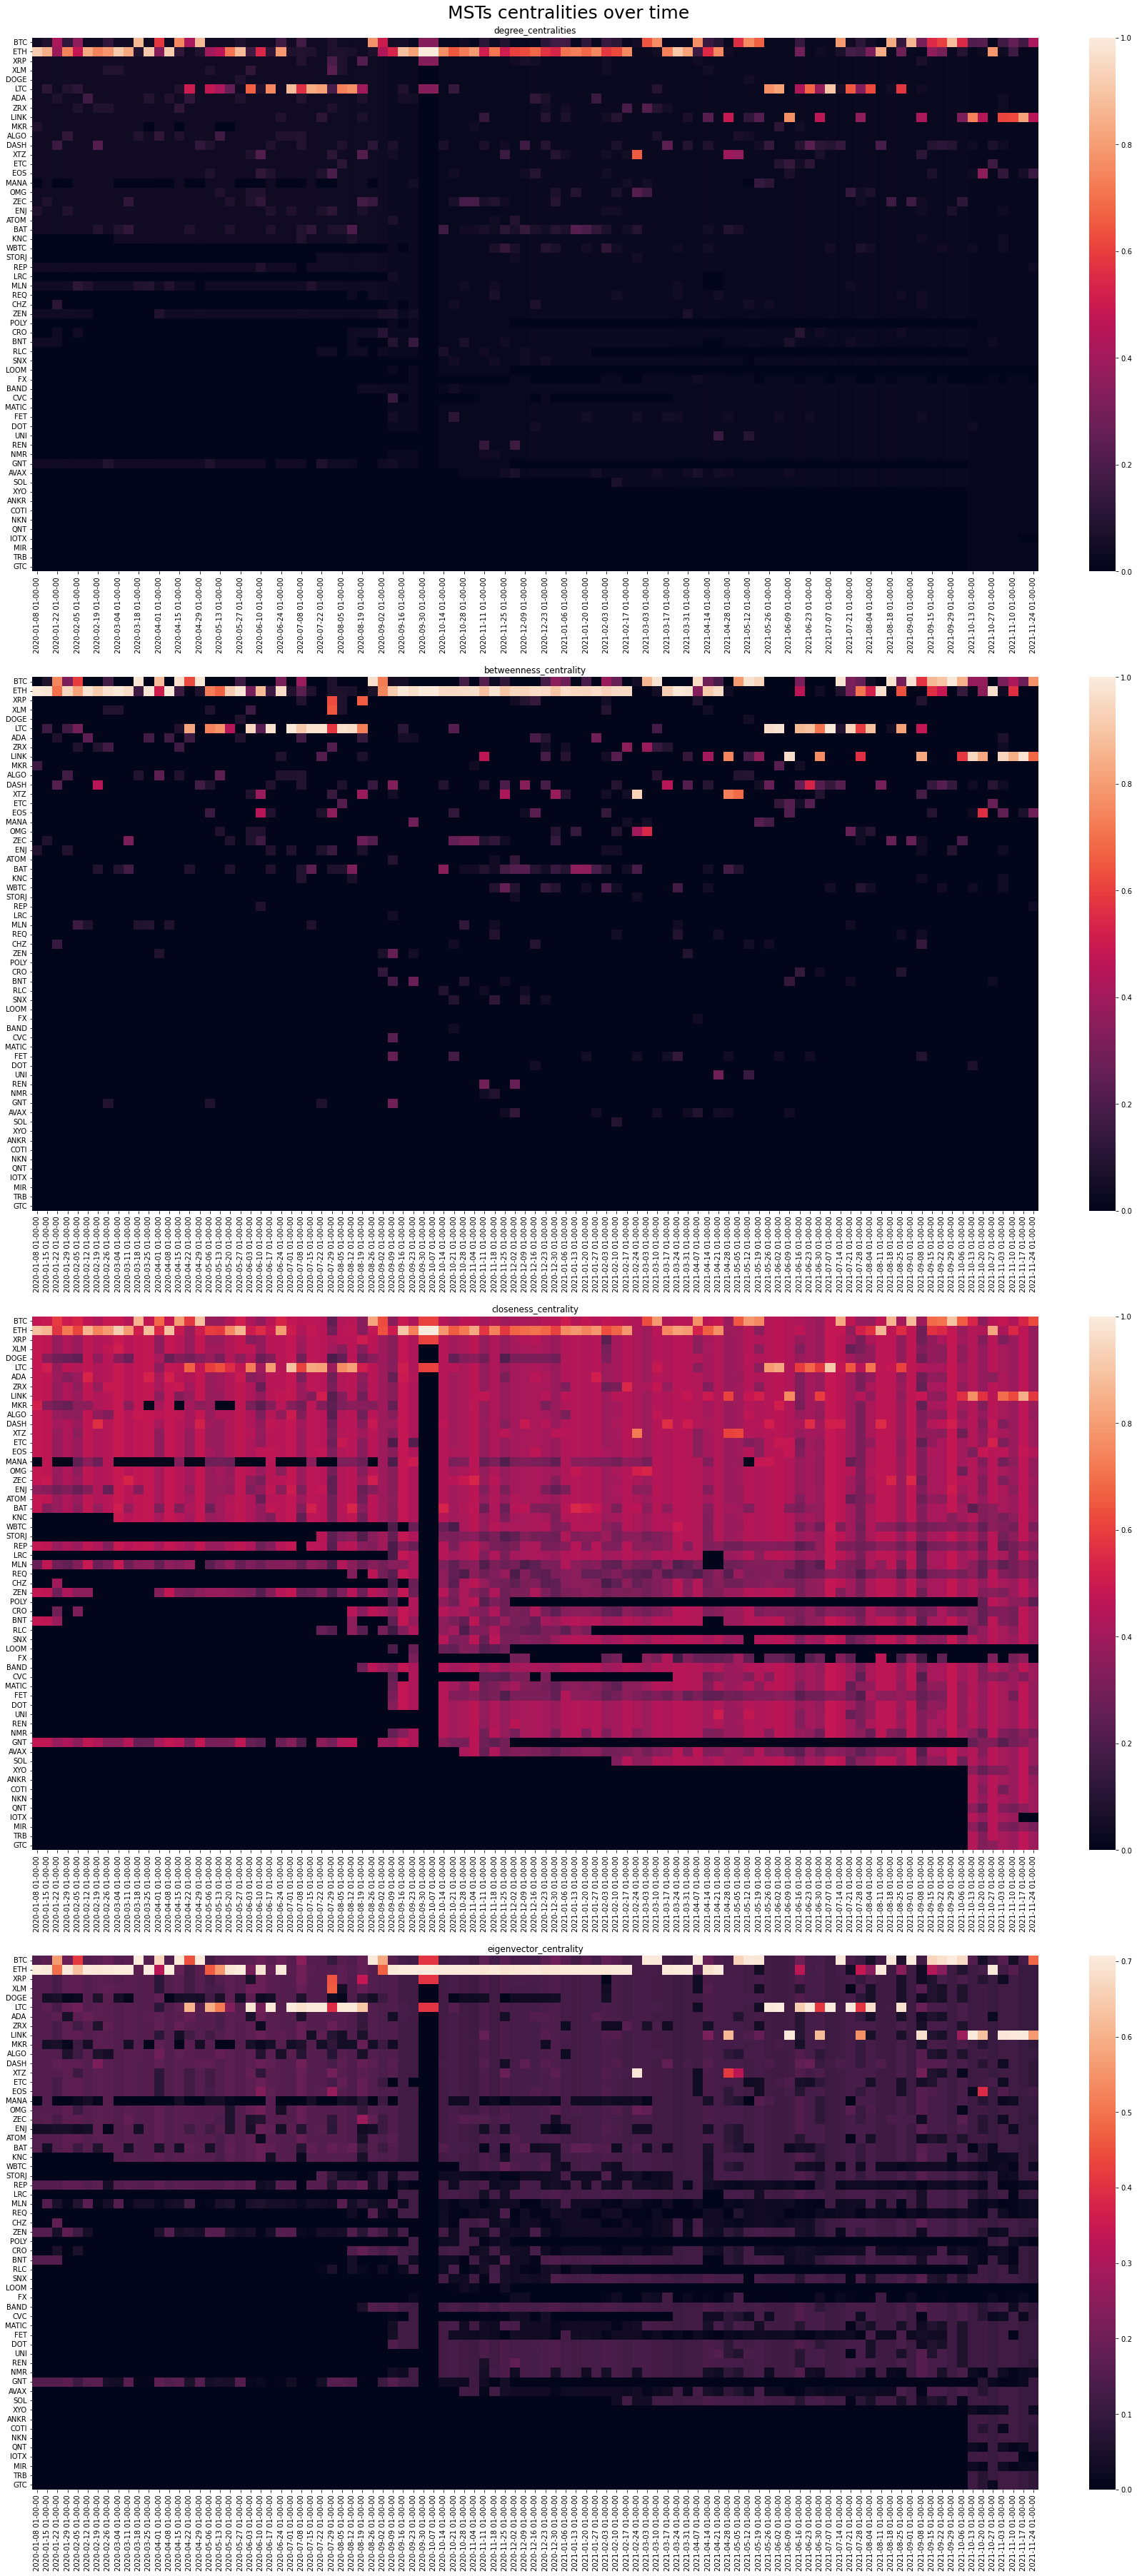

In [252]:
fig, axs = plt.subplots(4, figsize=(22,50) , constrained_layout=True)
sns.heatmap(df_degree_centralities_mst, ax=axs[0])
axs[0].set_title('degree_centralities')
sns.heatmap(df_betweenness_centrality_mst, ax=axs[1])
axs[1].set_title('betweenness_centrality')
sns.heatmap(df_closeness_centrality_mst, ax=axs[2])
axs[2].set_title('closeness_centrality')
sns.heatmap(df_eigenvector_centrality_mst, ax=axs[3])
axs[3].set_title('eigenvector_centrality')
fig.suptitle("MSTs centralities over time", fontsize=25)

Text(0.5, 0.98, 'PMFGs centralities over time')

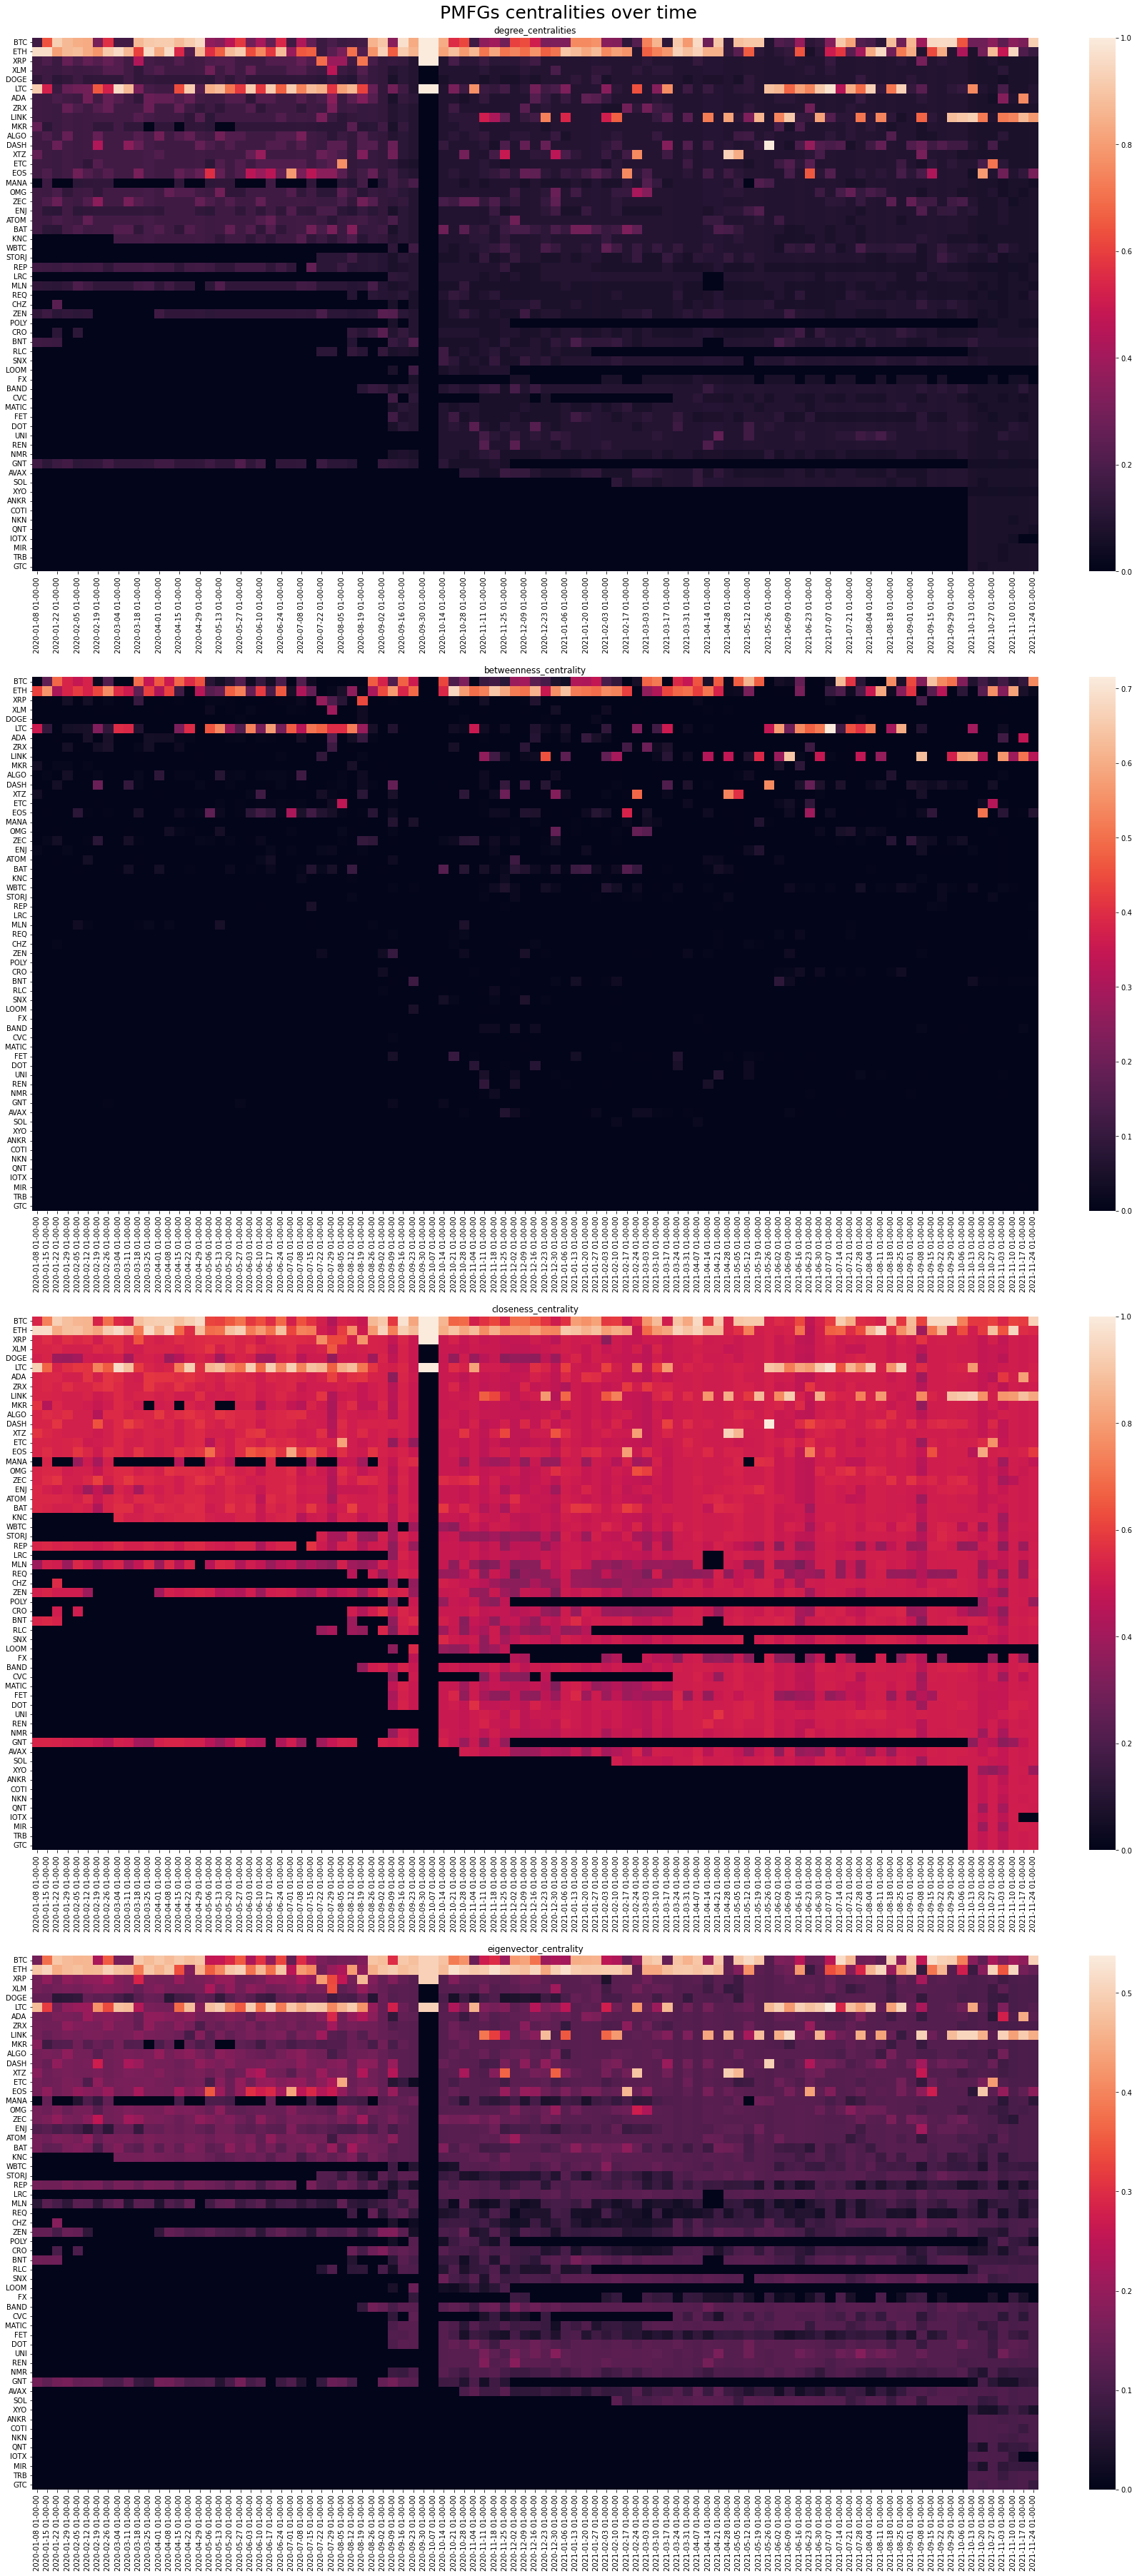

In [253]:
fig, axs = plt.subplots(4, figsize=(22,50) , constrained_layout=True)
sns.heatmap(df_degree_centralities_pmfg, ax=axs[0])
axs[0].set_title('degree_centralities')
sns.heatmap(df_betweenness_centrality_pmfg, ax=axs[1])
axs[1].set_title('betweenness_centrality')
sns.heatmap(df_closeness_centrality_pmfg, ax=axs[2])
axs[2].set_title('closeness_centrality')
sns.heatmap(df_eigenvector_centrality_pmfg, ax=axs[3])
axs[3].set_title('eigenvector_centrality')
fig.suptitle("PMFGs centralities over time", fontsize=25)

In [254]:
df_mst_propetries = pd.DataFrame.from_dict(msts_properties).T

df_pmfgs_properties = pd.DataFrame.from_dict(pmfgs_properties).T

In [255]:
df_mst_propetries

,nodes,degree_average,max_degree,average_shortest_path_length,diameter,normalized_tree_length,average_degree_centrality,average_betweenness_centrality,average_closeness_centrality
2020-01-08 01-00-00,25.0,1.920000,22.0,2.133333,4.0,2.083333,0.080000,0.049275,0.484620
2020-01-15 01-00-00,26.0,1.923077,21.0,2.200000,4.0,2.040000,0.076923,0.050000,0.469032
2020-01-22 01-00-00,27.0,1.925926,11.0,2.757835,5.0,1.692308,0.074074,0.070313,0.373545
2020-01-29 01-00-00,24.0,1.916667,17.0,2.543478,6.0,2.000000,0.083333,0.070158,0.411613
2020-02-05 01-00-00,26.0,1.923077,12.0,2.790769,6.0,1.880000,0.076923,0.074615,0.371181
...,...,...,...,...,...,...,...,...,...
2021-10-27 01-00-00,56.0,1.964286,43.0,2.337013,4.0,2.200000,0.035714,0.024759,0.438009
2021-11-03 01-00-00,55.0,1.963636,33.0,2.725926,6.0,2.092593,0.036364,0.032565,0.379618
2021-11-10 01-00-00,56.0,1.964286,34.0,2.760390,4.0,2.345455,0.035714,0.032600,0.369146
2021-11-17 01-00-00,55.0,1.963636,44.0,2.274747,4.0,1.870370,0.036364,0.024052,0.449031


In [256]:
df_pmfgs_properties

,nodes,degree_average,max_degree,average_shortest_path_length,diameter,normalized_tree_length,average_degree_centrality,average_betweenness_centrality,average_closeness_centrality
2020-01-08 01-00-00,25.0,5.520000,23.0,1.826667,3.0,0.652174,0.230000,0.035942,0.563715
2020-01-15 01-00-00,26.0,5.538462,24.0,1.806154,3.0,0.472222,0.221538,0.033590,0.564400
2020-01-22 01-00-00,27.0,5.555556,24.0,1.846154,3.0,0.373333,0.213675,0.033846,0.554430
2020-01-29 01-00-00,24.0,5.500000,20.0,1.880435,4.0,0.393939,0.239130,0.040020,0.548701
2020-02-05 01-00-00,26.0,5.538462,22.0,1.889231,3.0,0.402778,0.221538,0.037051,0.544223
...,...,...,...,...,...,...,...,...,...
2021-10-27 01-00-00,56.0,5.785714,48.0,1.992208,4.0,0.567901,0.105195,0.018374,0.509249
2021-11-03 01-00-00,55.0,5.781818,39.0,2.183165,4.0,0.628931,0.107071,0.022324,0.466725
2021-11-10 01-00-00,56.0,5.785714,52.0,1.926623,3.0,0.561728,0.105195,0.017160,0.525515
2021-11-17 01-00-00,55.0,5.781818,47.0,1.996633,3.0,0.572327,0.107071,0.018804,0.508960


<AxesSubplot:>

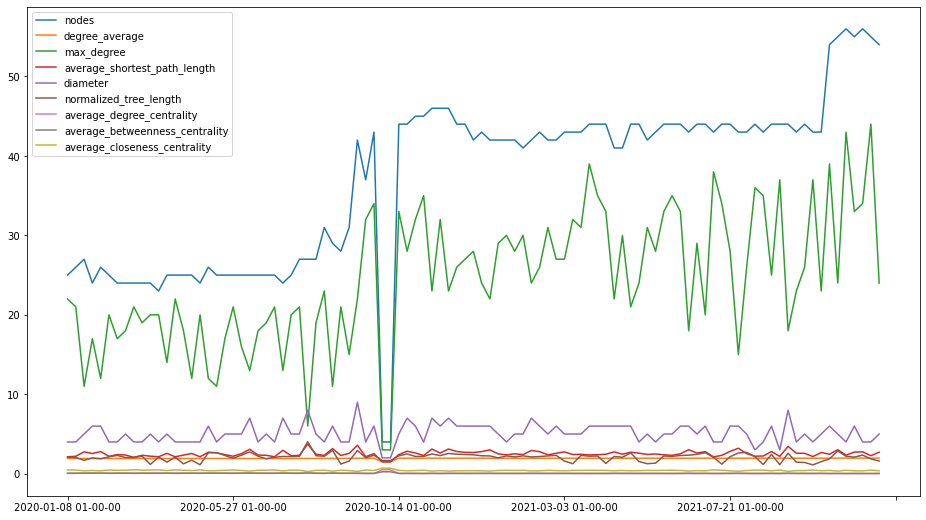

In [257]:
df_mst_propetries.plot(figsize=(16,9))

In [258]:
def plot_properties(df_mst_propetries, to_skip=[]):
    fig, ax1 = plt.subplots(figsize=(22, 12))


    color = 'tab:red'
    ax1.set_xlabel('time')
    #ax1.tick_params(axis='x', rotation=45)
    fig.autofmt_xdate(bottom=0.2, rotation=45, ha='right')


    ax1.set_ylabel('value', color=color)

    to_skip += ['nodes']
    for column in df_mst_propetries:
        if column in to_skip:
            continue
        ax1.plot(df_mst_propetries[column],label=column)
        ax1.tick_params(axis='y', labelcolor=color)

    ax1.legend(loc="upper left")

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('number of nodes', color=color)  # we already handled the x-label with ax1
    #ax2.plot(df_mst_propetries['nodes'], color='grey', alpha=0.5)
    ax2.fill_between(df_mst_propetries.index,df_mst_propetries['nodes'], color='lightgrey', alpha=0.25)
    ax2.tick_params(axis='y', labelcolor=color)

    #ticklabels = set([x[0:7] for x in df_mst_propetries.index])
    #ax1.set_xticks(np.arange(1,len(ticklabels)+1))
    #ax1.set_xticks(np.round(np.linspace(0, len(df_mst_propetries.index) - 1, len(ticklabels))).astype(int))
    #ax1.set_xticklabels(ticklabels, rotation=30, ha='right') #add monthlabels to the xaxis

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

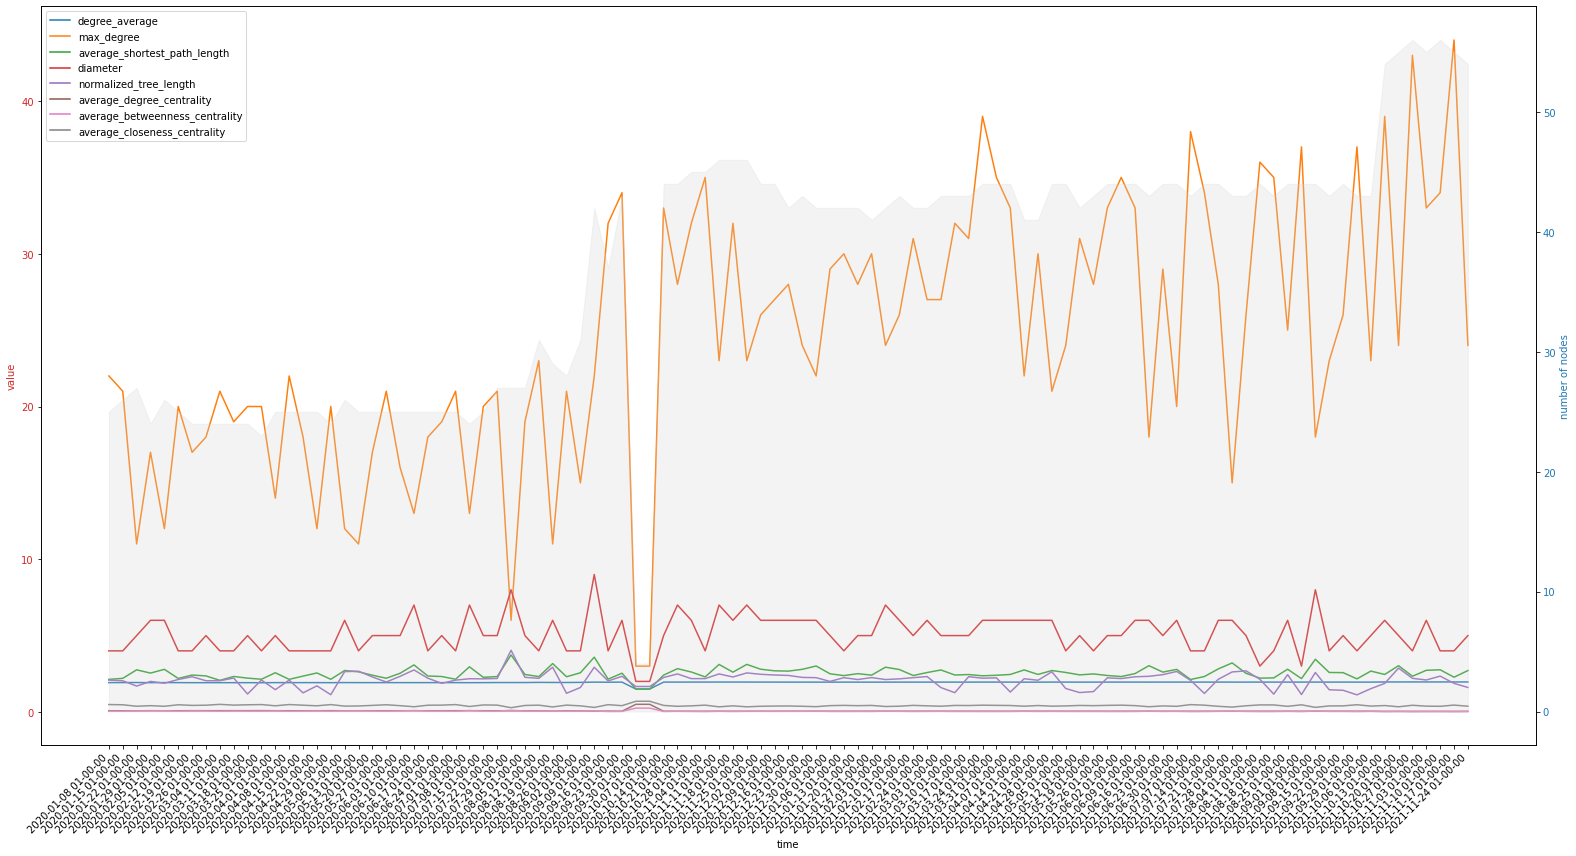

In [259]:
plot_properties(df_mst_propetries)

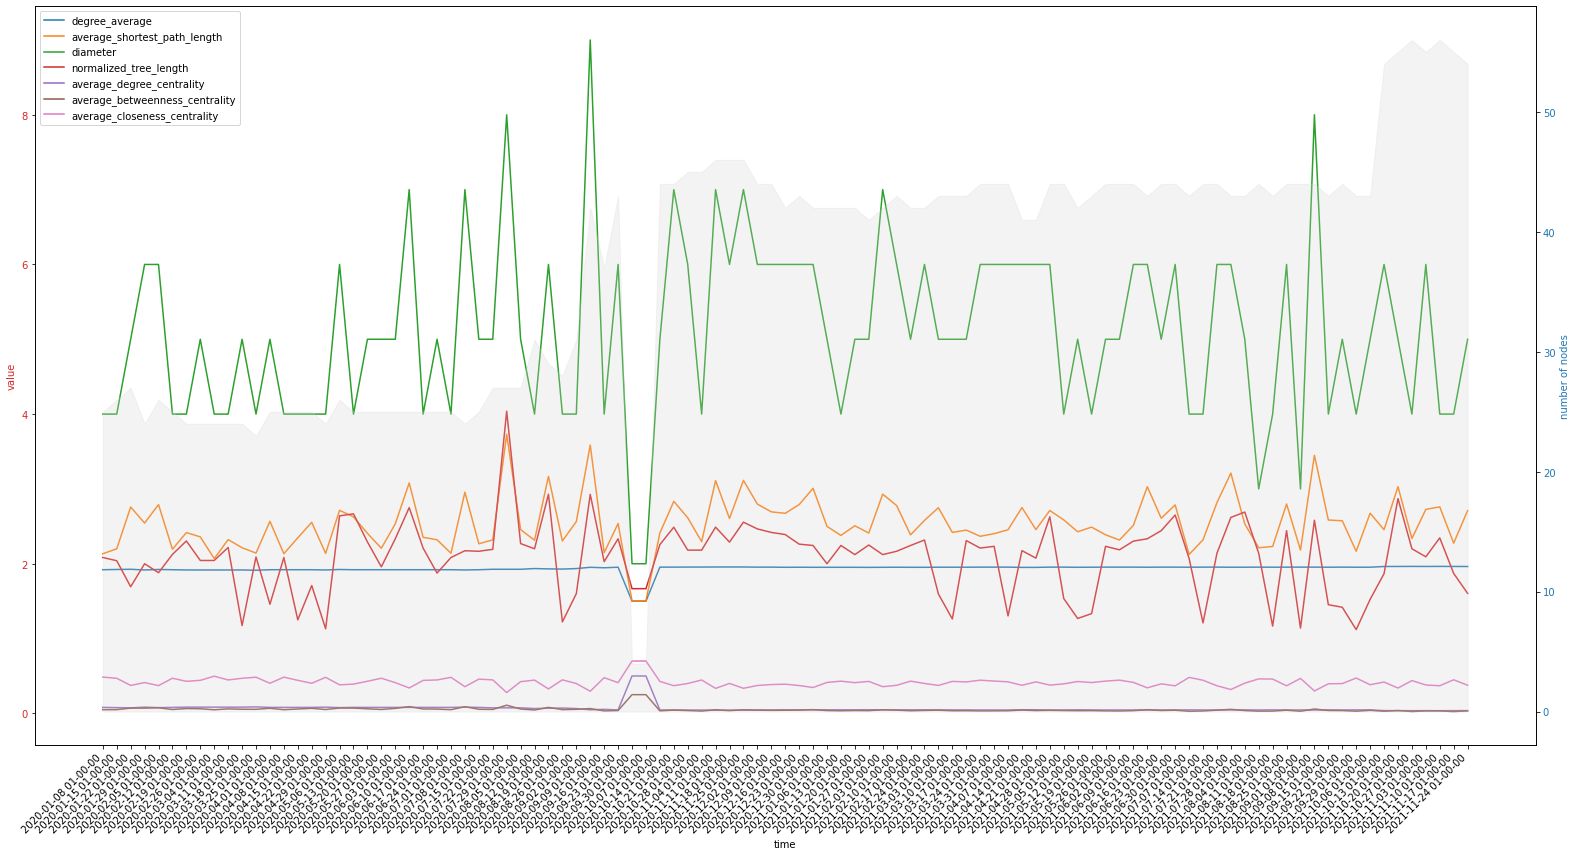

In [260]:
plot_properties(df_mst_propetries, ['max_degree'])

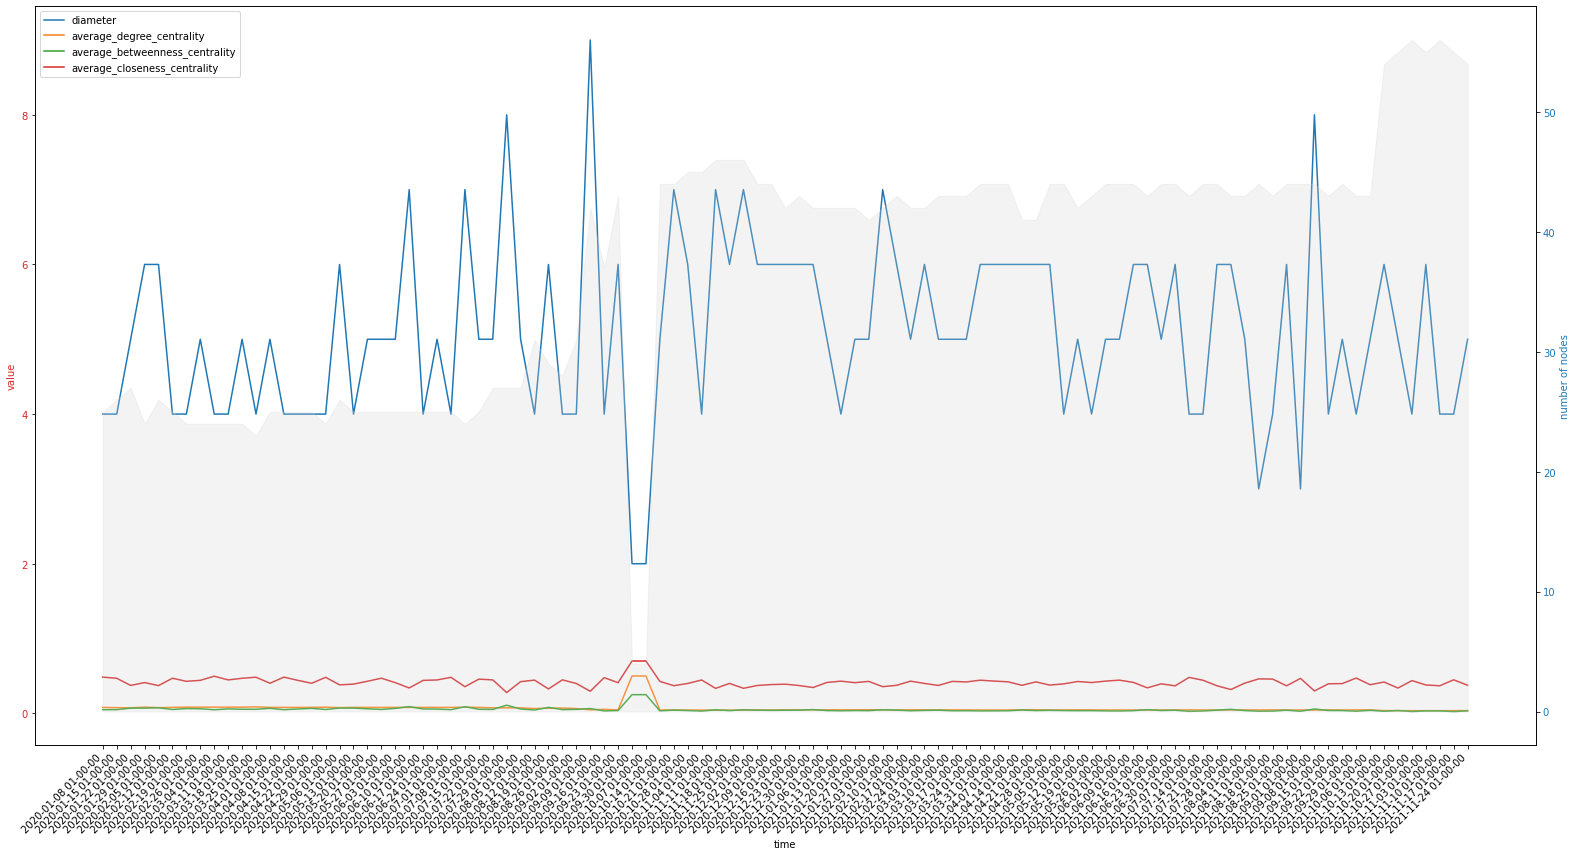

In [261]:
plot_properties(df_mst_propetries, ['max_degree', 'degree_average', 'average_shortest_path_length', 'normalized_tree_length'])

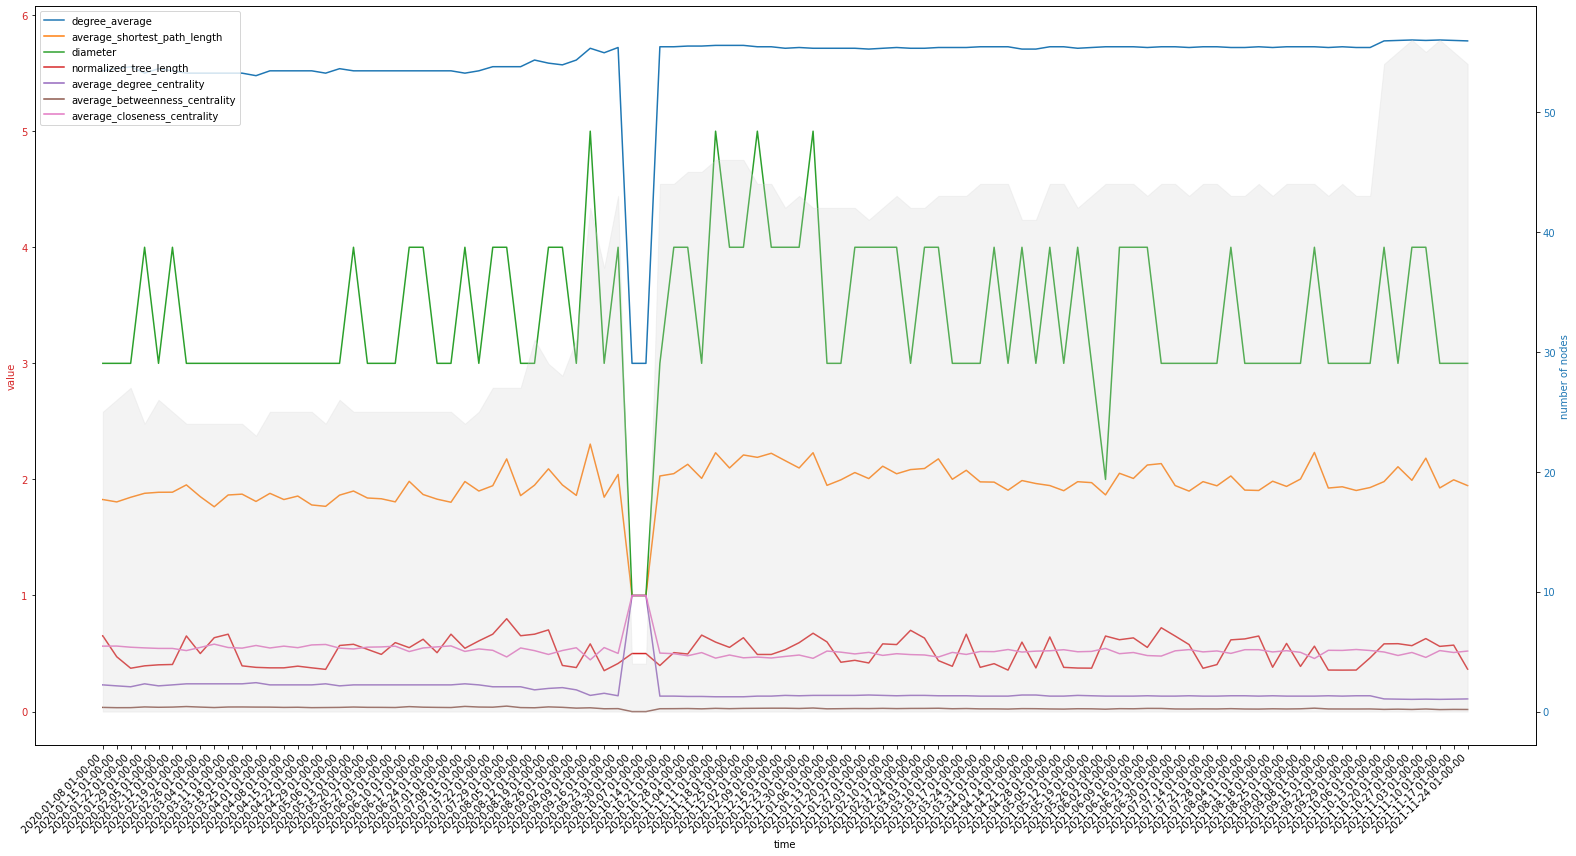

In [262]:
plot_properties(df_pmfgs_properties, ['max_degree'])